# Chicago Transit Authority: Bus Ridership


Source of data:
* CTA Ridership: Bus Routes Monthly: https://data.cityofchicago.org/Transportation/CTA-Ridership-Bus-Routes-Monthly-Day-Type-Averages/bynn-gwxy
This dataset shows monthly averages, by day type (weekday, Saturday or Sunday/Holiday) and monthly totals for all CTA bus routes, back to 2001. 


In [17]:
inyear = 2014 # Enter year here (from 2001 to 2015)
def getdata(year=inyear):
    df = pd.read_csv('data/CTA_-_Ridership_-_Bus_Routes_-_Monthly_Day-Type_Averages___Totals.csv')
    df = df[['route', 'routename', 'Month_Beginning', 'Avg_Weekday_Rides', 'Avg_Saturday_Rides', 'Avg_Sunday-Holiday_Rides', 'MonthTotal']]
    df['year'] = pd.DatetimeIndex(df['Month_Beginning']).year
    
    df = df[df['year'] == int(year)]  # get data base on the given year in the argument
    df['month'] = pd.DatetimeIndex(df['Month_Beginning']).month

    df.set_index(['route', 'routename'], inplace=True)
    return df

# inyear = 2014 # Enter year here (from 2001 to 2015)
# from cta_data import getdata
df_ridership = getdata(inyear)
df_ridership.head()

,,Month_Beginning,Avg_Weekday_Rides,Avg_Saturday_Rides,Avg_Sunday-Holiday_Rides,MonthTotal,year,month
route,routename,,,,,,,
48,South Damen,4/1/2014,1129.0,0.0,0.0,24837,2014,4
1,Bronzeville/Union Station,1/1/2014,1922.2,0.0,0.0,42289,2014,1
2,Hyde Park Express,1/1/2014,2851.4,0.0,0.0,62731,2014,1
3,King Drive,1/1/2014,16042.3,11140.6,6615.7,430571,2014,1
4,Cottage Grove,1/1/2014,18263.3,12125.6,8494.7,492768,2014,1


In [18]:
# Import the pandas module
import pandas as pd
df_groups = pd.read_csv('data/CTA_BUS_ROUTE_GROUPS.csv')
df_groups.dropna(how='any', inplace=True)
df_groups.set_index(['route', 'routename'], inplace=True)
df_groups.head()

,,routegroup
route,routename,
1,Bronzeville/Union Station,South Side Downtown
2,Hyde Park Express,South Side Lake Shore Drive
3,King Drive,South Side Downtown
4,Cottage Grove,South Side Downtown
5,South Shore Night Bus,South Side East-West


In [19]:
# Join by route column
df_joined = df_ridership.join(df_groups)

# Perform some data cleaning and reset the index
df_joined.dropna(how='any', inplace=True)
df_joined.reset_index(inplace=True)

# Sort the new dataframe by route group
df_joined.sort_values(['routegroup', 'route', 'routename'], ascending=[True, True, True], inplace=True)
df_joined.head()

,route,routename,Month_Beginning,Avg_Weekday_Rides,Avg_Saturday_Rides,Avg_Sunday-Holiday_Rides,MonthTotal,year,month,routegroup
156,121,Union/Streeterville Express,1/1/2014,1510.5,0.0,0.0,33231,2014,1,Downtown
157,121,Union/Streeterville Express,2/1/2014,1679.5,0.0,0.0,33590,2014,2,Downtown
158,121,Union/Streeterville Express,3/1/2014,1614.7,0.0,0.0,33909,2014,3,Downtown
159,121,Union/Streeterville Express,4/1/2014,1536.9,0.0,0.0,33812,2014,4,Downtown
160,121,Union/Streeterville Express,5/1/2014,1502.1,0.0,0.0,31544,2014,5,Downtown


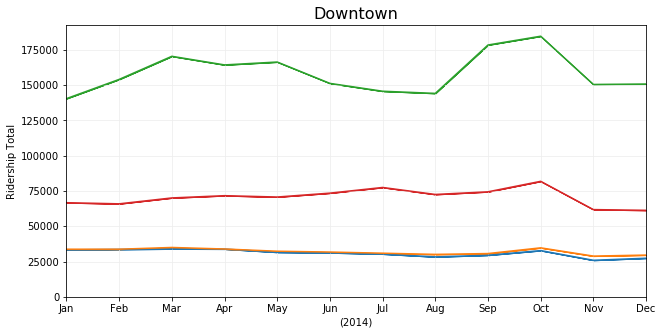

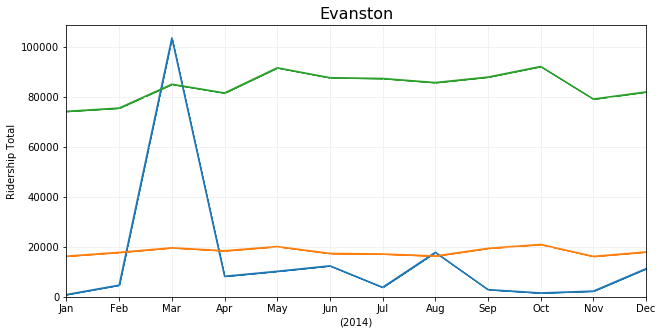

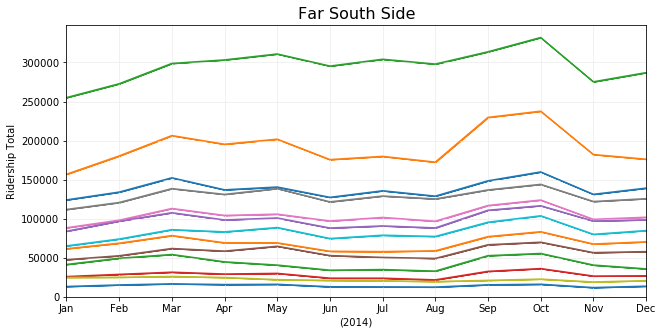

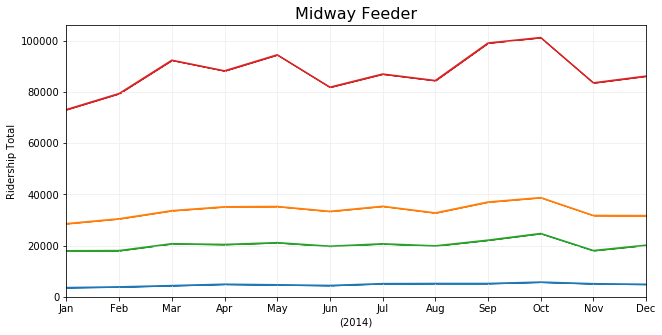

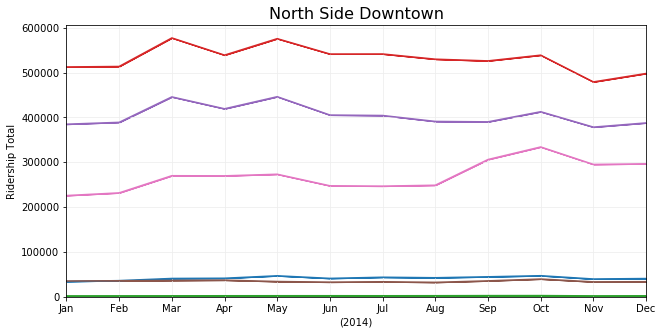

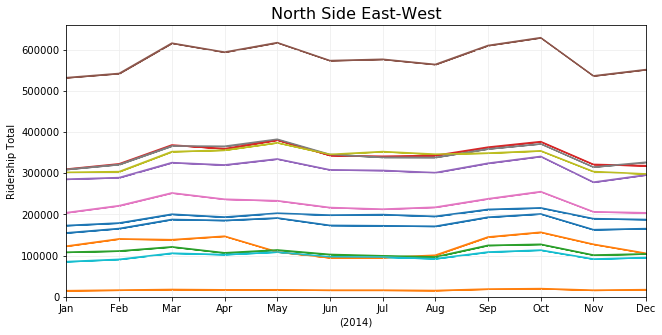

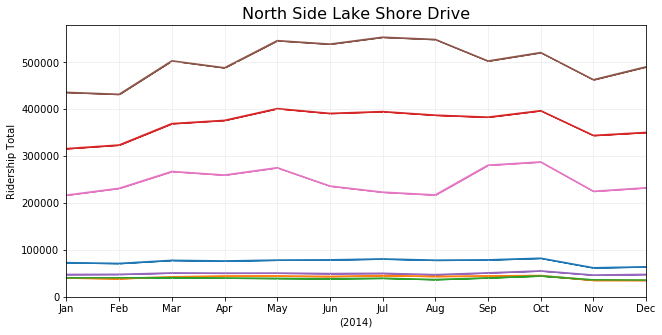

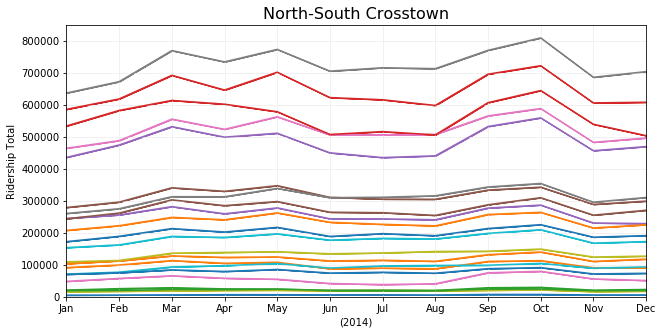

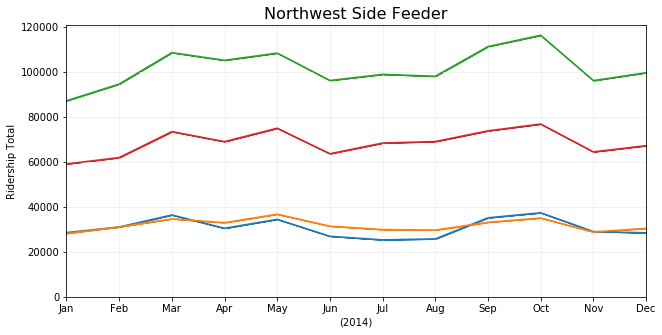

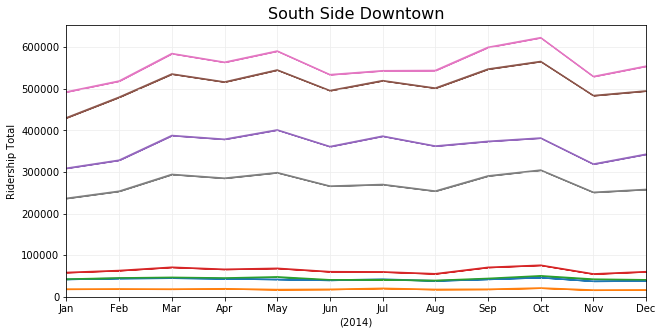

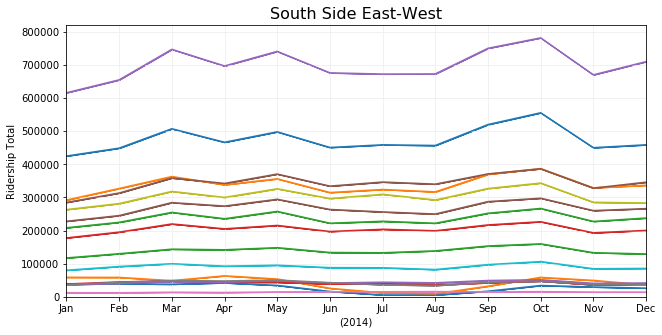

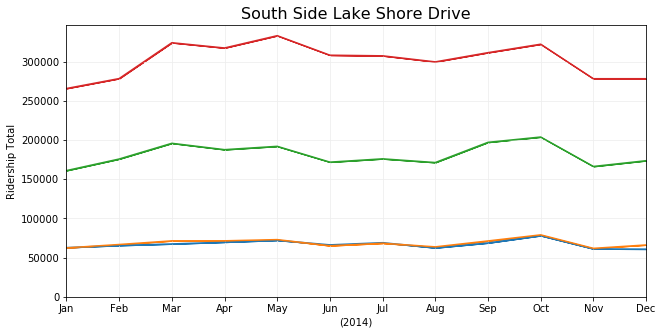

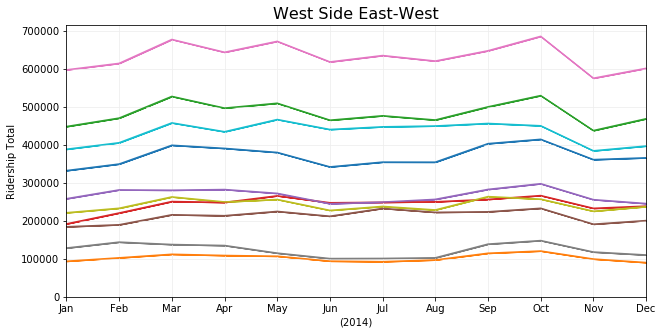

In [20]:
# Now, plot!
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import calendar

# using mpld3 library to leverage the function for creating tooltips for the markers in the scatter plot. 
import mpld3
from mpld3 import plugins
mpld3.enable_notebook()

routegroups = df_joined['routegroup'].unique()

for routegroup in routegroups:
    
    routes = df_joined['routename'][df_joined['routegroup'] == routegroup].unique()
    dfx =pd.DataFrame()
    for route in routes:
        d1 = df_joined[['month', 'MonthTotal']][df_joined['routename'] == route]
        
        d1.set_index('month', inplace=True)
        d1.columns = [route]
        
        if len(dfx) > 0:
            dfx = dfx.join(d1)
        else:
            dfx = d1    
    
    fig, axes = plt.subplots()
    fig.set_size_inches(14,5)
    for key, val in dfx.iteritems():
        l, = axes.plot(val.index, val.values, label=key, alpha=2)
        axes.fill_between(val.index, val.values, val.values, color=l.get_color())

    axes.set_ylim(ymin=0)
    axes.set_xlim(xmin=1, xmax=12)  
    
# define interactive legend
    handles, labels = axes.get_legend_handles_labels() # return lines and labels
    interactive_legend = plugins.InteractiveLegendPlugin(zip(handles, axes.collections),
                                                         labels,
                                                         alpha_unsel=0.2,
                                                         alpha_over=2, 
                                                         start_visible=False)
    plugins.connect(fig, interactive_legend)

# define tooltip
    for i in range(len(labels)):
        tooltip = mpld3.plugins.LineLabelTooltip(axes.get_lines()[i], labels[i], hoffset=2, voffset=1,)
        mpld3.plugins.connect(plt.gcf(), tooltip) 
  
    plt.title(routegroup, size=16)
    plt.xticks(np.arange(1,13), calendar.month_abbr[1:13])
    plt.grid(color='#eeeeee', linestyle='solid')
    plt.xlabel('({0})'.format(inyear))
    plt.ylabel('Ridership Total')  
    plt.subplots_adjust(right=.7)
